# Figures for Paper

## SODA (as same period as SOSE)

In [2]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(15)

client = cluster.get_client()

In [4]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.1de124c4a0d2402fbfe2906833d0246a Dashboard: /services/dask-gateway/clusters/prod.1de124c4a0d2402fbfe2906833d0246a/status,Cluster Workers: 15 Cores: 30 Memory: 128.85 GB


In [5]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
from fastjmd95 import jmd95numba

In [64]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms#.load()

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>

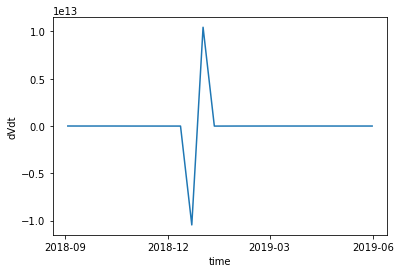

In [67]:
wmt_budget_terms.sel(time=slice('2018-09', '2019-05')).dVdt.sum('sigma2_bin').plot()

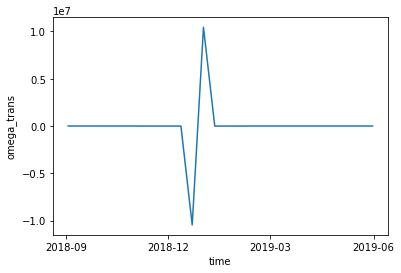

In [70]:
wmt_budget_terms.sel(time=slice('2018-09', '2019-05')).omega_trans.sum('sigma2_bin').plot()

### --- Converting time from Julian to datetime64[ns] object ---

In [7]:
wmt_budget_terms.time

<xarray.DataArray 'time' (time: 985)>
array([cftime.DatetimeJulian(1993, 1, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 17, 1, 0, 0, 0),
       cftime.DatetimeJulian(1993, 1, 27, 1, 0, 0, 0), ...,
       cftime.DatetimeJulian(2019, 11, 27, 1, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 7, 1, 0, 0, 0),
       cftime.DatetimeJulian(2019, 12, 17, 1, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1993-01-07 01:00:00 ... 2019-12-17 01:00:00
Attributes:
    bounds:          time_bounds
    calendar_type:   JULIAN
    cartesian_axis:  T
    long_name:       time

In [8]:
wmt_budget_terms.indexes['time']

CFTimeIndex([1993-01-07 01:00:00, 1993-01-17 01:00:00, 1993-01-27 01:00:00,
             1993-02-06 01:00:00, 1993-02-16 01:00:00, 1993-02-26 01:00:00,
             1993-03-08 01:00:00, 1993-03-18 01:00:00, 1993-03-28 01:00:00,
             1993-04-07 01:00:00,
             ...
             2019-09-18 01:00:00, 2019-09-28 01:00:00, 2019-10-08 01:00:00,
             2019-10-18 01:00:00, 2019-10-28 01:00:00, 2019-11-07 01:00:00,
             2019-11-17 01:00:00, 2019-11-27 01:00:00, 2019-12-07 01:00:00,
             2019-12-17 01:00:00],
            dtype='object', length=985, calendar='julian', freq='10D')

In [9]:
datetimeindex = wmt_budget_terms.indexes['time'].to_datetimeindex()
datetimeindex

<ipython-input-9-04ed172524c5>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = wmt_budget_terms.indexes['time'].to_datetimeindex()


DatetimeIndex(['1993-01-07 01:00:00', '1993-01-17 01:00:00',
               '1993-01-27 01:00:00', '1993-02-06 01:00:00',
               '1993-02-16 01:00:00', '1993-02-26 01:00:00',
               '1993-03-08 01:00:00', '1993-03-18 01:00:00',
               '1993-03-28 01:00:00', '1993-04-07 01:00:00',
               ...
               '2019-09-18 01:00:00', '2019-09-28 01:00:00',
               '2019-10-08 01:00:00', '2019-10-18 01:00:00',
               '2019-10-28 01:00:00', '2019-11-07 01:00:00',
               '2019-11-17 01:00:00', '2019-11-27 01:00:00',
               '2019-12-07 01:00:00', '2019-12-17 01:00:00'],
              dtype='datetime64[ns]', length=985, freq=None)

In [10]:
wmt_budget_terms['time'] = datetimeindex

In [11]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:         (sigma2_bin: 699, time: 985)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03
  * time            (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T...
Data variables:
    dVdt            (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    omega_trans     (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    psi_vel         (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_left   (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    u_binned_right  (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>
    v_binned        (time, sigma2_bin) float64 dask.array<chunksize=(247, 175), meta=np.ndarray>

### --- Converted time from Julian to datetime64[ns] object --- 

In [12]:
seaice = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/seaice.zarr'))

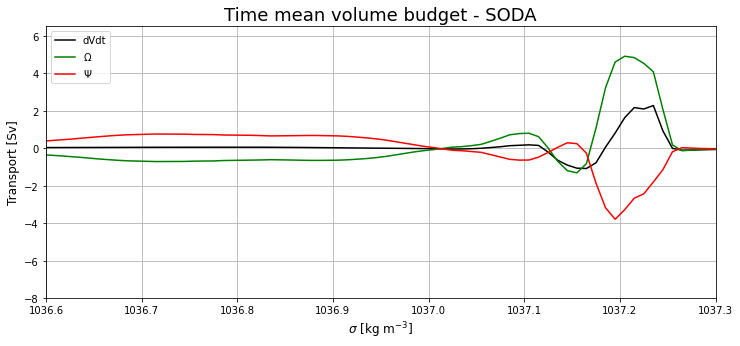

In [13]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dVdt', color='k')
wmt_budget_terms.omega_trans.mean(dim='time').plot(label=r'$\Omega$', color='green')
wmt_budget_terms.psi_vel.mean(dim='time').plot(label=r'$\Psi$', color='red')
plt.grid()
plt.legend()
plt.xlim(1036.6, 1037.3)
plt.ylim(-8,6.5)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
#plt.title(r'WMT volume budget in $\sigma$ space', fontsize=18);
plt.title('Time mean volume budget - SODA', fontsize=18);

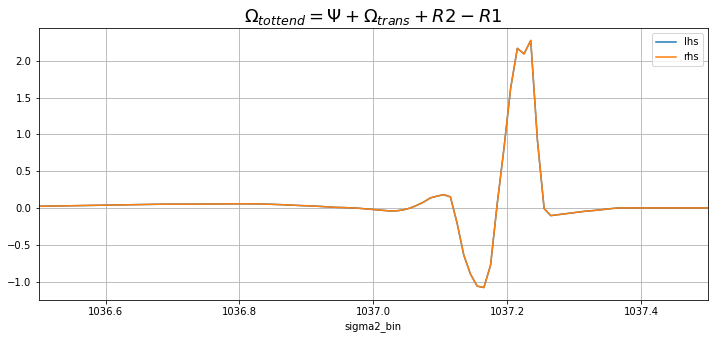

In [14]:
plt.figure(figsize=(12,5))
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='lhs')
(wmt_budget_terms.omega_trans + wmt_budget_terms.psi_vel).mean(dim='time').plot(label='rhs')
plt.grid()
plt.legend()
plt.xlim(1036.5, 1037.5)
plt.title(r'$\Omega_{tottend} = \Psi + \Omega_{trans} + R2 - R1$', fontsize=18, fontweight='bold');

In [15]:
wmt_budget_terms.time.sel(time='2010', method='nearest')

<xarray.DataArray 'time' (time: 36)>
array(['2010-01-08T01:00:00.000000000', '2010-01-18T01:00:00.000000000',
       '2010-01-28T01:00:00.000000000', '2010-02-07T01:00:00.000000000',
       '2010-02-17T01:00:00.000000000', '2010-02-27T01:00:00.000000000',
       '2010-03-09T01:00:00.000000000', '2010-03-19T01:00:00.000000000',
       '2010-03-29T01:00:00.000000000', '2010-04-08T01:00:00.000000000',
       '2010-04-18T01:00:00.000000000', '2010-04-28T01:00:00.000000000',
       '2010-05-08T01:00:00.000000000', '2010-05-18T01:00:00.000000000',
       '2010-05-28T01:00:00.000000000', '2010-06-07T01:00:00.000000000',
       '2010-06-17T01:00:00.000000000', '2010-06-27T01:00:00.000000000',
       '2010-07-07T01:00:00.000000000', '2010-07-17T01:00:00.000000000',
       '2010-07-27T01:00:00.000000000', '2010-08-06T01:00:00.000000000',
       '2010-08-16T01:00:00.000000000', '2010-08-26T01:00:00.000000000',
       '2010-09-05T01:00:00.000000000', '2010-09-15T01:00:00.000000000',
       '2010-09-25T01:00:00.000000000', '2010-10-05T01:00:00.000000000',
       '2010-10-15T01:00:00.000000000', '2010-10-25T01:00:00.000000000',
       '2010-11-04T01:00:00.000000000', '2010-11-14T01:00:00.000000000',
       '2010-11-24T01:00:00.000000000', '2010-12-04T01:00:00.000000000',
       '2010-12-14T01:00:00.000000000', '2010-12-24T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2010-01-08T01:00:00 ... 2010-12-24T01:00:00

In [16]:
wmt_budget_terms.dVdt.groupby('time.month').mean(dim='time')

<xarray.DataArray 'dVdt' (month: 12, sigma2_bin: 699)>
dask.array<stack, shape=(12, 699), dtype=float64, chunksize=(1, 175), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [17]:
def anom(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    anom_chunk = anom.chunk({'time':-1, 'sigma2_bin':-1})
    anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [18]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'),
                    wmt_budget_terms.psi_vel.rename('psi_vel'),
                    wmt_budget_terms.omega_trans.rename('omega_trans')])


In [19]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [20]:
clim_ds = anom_ds

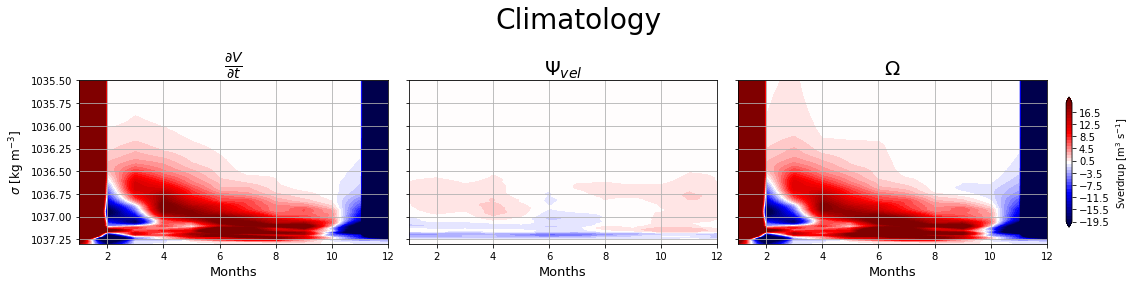

In [21]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(16, 4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax0.contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_xlabel('Months', fontsize=13)
ax0.set_ylim(1037.3, 1035.5)
#ax[0,0].set_xlim(xmin='1993')
ax0.grid()

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax1.contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_xlabel('Months', fontsize=13)
ax1.set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax1.grid()

omega_clim = clim(clim_ds.omega_trans)
c_omega = ax2.contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_xlabel('Months', fontsize=13)
ax2.set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax2.grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

In [22]:
year_start_index = [0, 36, 73, 109, 146, 182, 219, 255, 292, 329, 
                    365, 402, 438, 475, 511, 548, 584, 621, 657, 
                    694, 730, 767, 803, 840, 876, 913, 949]

In [23]:
wmt_budget_terms.psi_vel.time.values[year_start_index]

array(['1993-01-07T01:00:00.000000000', '1994-01-02T01:00:00.000000000',
       '1995-01-07T01:00:00.000000000', '1996-01-02T01:00:00.000000000',
       '1997-01-06T01:00:00.000000000', '1998-01-01T01:00:00.000000000',
       '1999-01-06T01:00:00.000000000', '2000-01-01T01:00:00.000000000',
       '2001-01-05T01:00:00.000000000', '2002-01-10T01:00:00.000000000',
       '2003-01-05T01:00:00.000000000', '2004-01-10T01:00:00.000000000',
       '2005-01-04T01:00:00.000000000', '2006-01-09T01:00:00.000000000',
       '2007-01-04T01:00:00.000000000', '2008-01-09T01:00:00.000000000',
       '2009-01-03T01:00:00.000000000', '2010-01-08T01:00:00.000000000',
       '2011-01-03T01:00:00.000000000', '2012-01-08T01:00:00.000000000',
       '2013-01-02T01:00:00.000000000', '2014-01-07T01:00:00.000000000',
       '2015-01-02T01:00:00.000000000', '2016-01-07T01:00:00.000000000',
       '2017-01-01T01:00:00.000000000', '2018-01-06T01:00:00.000000000',
       '2019-01-01T01:00:00.000000000'], dtype='dat

In [24]:
anom(anom_ds.dVdt)

<ipython-input-17-3d3384b88b7f>:5: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  anom_rolled = anom_chunk.rolling(time=36).mean(dim='time') #annual rolling mean to remove seasonal cycle


<xarray.DataArray 'dVdt' (time: 985, sigma2_bin: 699)>
dask.array<where, shape=(985, 699), dtype=float64, chunksize=(967, 699), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.032e+03 1.032e+03 ... 1.039e+03 1.039e+03
  * time        (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:0...
    month       (time) int64 dask.array<chunksize=(985,), meta=np.ndarray>

In [25]:
import warnings
warnings.filterwarnings("ignore")

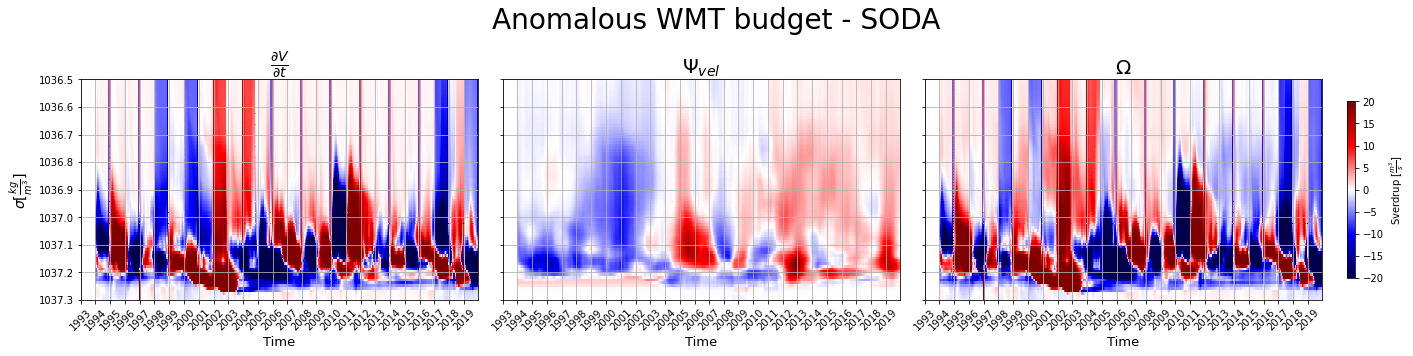

In [26]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 5), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})#, sharex=True)

#ax00 = ax0.twinx()
#ax10 = ax1.twinx()
#ax20 = ax2.twinx()

dVdt_anom_rolled = anom(anom_ds.dVdt) / 1e6
c = ax0.pcolormesh(dVdt_anom_rolled.time, 
                   dVdt_anom_rolled.sigma2_bin, 
                   dVdt_anom_rolled.T, vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax0)
ax0.set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax0.set_ylim(1037.3, 1036.5)
ax0.set_xticks(dVdt_anom_rolled.time.values[year_start_index])
ax0.set_xticklabels(ax0.get_xticks(), rotation = 45)
ax0.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax0.set_xlabel('Time', fontsize=13)
#ax00.plot(sam.time.isel(index=slice(49, 54)), sam.ANN.isel(index=slice(49, 54)))
#ax00.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax0.grid()

psi_vel_anom_rolled = anom(anom_ds.psi_vel)
c_psi = ax1.pcolormesh(psi_vel_anom_rolled.time, psi_vel_anom_rolled.sigma2_bin, psi_vel_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax1)
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title(r'$\Psi_{vel}$', fontsize=20)
ax1.set_ylim(1037.3, 1036.5)
ax1.set_xticks(psi_vel_anom_rolled.time.values[year_start_index])
ax1.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax1.set_xlabel('Time', fontsize=13)
#ax10.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax1.grid()

omega_anom_rolled = anom(anom_ds.omega_trans)
c_omega = ax2.pcolormesh(omega_anom_rolled.time, omega_anom_rolled.sigma2_bin, omega_anom_rolled.T,
                        vmin=-20, vmax=20, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax2)
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax2.set_title(r'$\Omega$', fontsize=20)
ax2.set_ylim(1037.3, 1036.5)
ax2.set_xticks(omega_anom_rolled.time.values[year_start_index])
ax2.set_xticklabels([str(i) for i in np.arange(1993, 2020)], rotation = 45)
ax2.set_xlabel('Time', fontsize=13)
#ax20.plot(dVdt_anom_rolled.time.values[year_start_index], sam.ANN.isel(index=slice(50, 55)))
ax2.grid()

plt.suptitle('Anomalous WMT budget - SODA', fontsize=28)
plt.tight_layout();

## Loading in Sea ice, SAM, ENSO timeseries

In [27]:
soda = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SODA/datasets/soda_si_index.zarr'))
sam = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/SAM-index/sam_index')
enso = xr.open_dataarray('/home/jovyan/WMT-project/Climate-Indices/ENSO-index/oni')

In [28]:
soda.indexes

time: CFTimeIndex([1992-01-05 13:00:00, 1992-01-10 13:00:00, 1992-01-15 13:00:00,
                   1992-01-20 13:00:00, 1992-01-25 13:00:00, 1992-01-30 13:00:00,
                   1992-02-04 13:00:00, 1992-02-09 13:00:00, 1992-02-14 13:00:00,
                   1992-02-19 13:00:00,
                   ...
                   2020-11-08 13:00:00, 2020-11-13 13:00:00, 2020-11-18 13:00:00,
                   2020-11-23 13:00:00, 2020-11-28 13:00:00, 2020-12-03 13:00:00,
                   2020-12-08 13:00:00, 2020-12-13 13:00:00, 2020-12-18 13:00:00,
                   2020-12-23 13:00:00],
                  dtype='object', length=2117, calendar='julian', freq='5D')

In [29]:
datetime_soda = soda.indexes['time'].to_datetimeindex()
datetime_soda

DatetimeIndex(['1992-01-05 13:00:00', '1992-01-10 13:00:00',
               '1992-01-15 13:00:00', '1992-01-20 13:00:00',
               '1992-01-25 13:00:00', '1992-01-30 13:00:00',
               '1992-02-04 13:00:00', '1992-02-09 13:00:00',
               '1992-02-14 13:00:00', '1992-02-19 13:00:00',
               ...
               '2020-11-08 13:00:00', '2020-11-13 13:00:00',
               '2020-11-18 13:00:00', '2020-11-23 13:00:00',
               '2020-11-28 13:00:00', '2020-12-03 13:00:00',
               '2020-12-08 13:00:00', '2020-12-13 13:00:00',
               '2020-12-18 13:00:00', '2020-12-23 13:00:00'],
              dtype='datetime64[ns]', length=2117, freq=None)

In [30]:
soda['time'] = datetime_soda
soda.soda_si_index

<xarray.DataArray 'soda_si_index' (time: 2117)>
dask.array<xarray-soda_si_index, shape=(2117,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    month    (time) int64 dask.array<chunksize=(2117,), meta=np.ndarray>
  * time     (time) datetime64[ns] 1992-01-05T13:00:00 ... 2020-12-23T13:00:00

In [31]:
soda_mo = soda.resample(time='MS').mean()
soda_mo

<xarray.Dataset>
Dimensions:        (time: 348)
Coordinates:
  * time           (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
Data variables:
    soda_si_index  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [32]:
enso.time.sel(time=slice('1992', '2020'))

<xarray.DataArray 'time' (time: 348)>
array(['1992-01-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1992-03-01T00:00:00.000000000', ..., '2020-10-01T00:00:00.000000000',
       '2020-11-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01
    month    (time) int64 ...
Attributes:
    long_name:        Time
    delta_t:          0000-01-00 00:00:00
    avg_period:       0000-01-00 00:00:00
    prev_avg_period:  0000-00-07 00:00:00
    standard_name:    time
    axis:             T
    actual_range:     [19723. 80931.]
    _ChunkSizes:      1

In [33]:
sam.sel(time=slice('1992', '2020'))

<xarray.DataArray (time: 348)>
array([-0.122525, -0.885817, -0.616002, ...,  0.994549,  0.653681,  1.19673 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-31 1992-02-29 ... 2020-12-31
    month    (time) int64 ...

In [34]:
sam_soda_time = sam.sel(time=slice('1992', '2020')).assign_coords(coords={'time':soda_mo.time}).drop(['month'])
sam_soda_time

<xarray.DataArray (time: 348)>
array([-0.122525, -0.885817, -0.616002, ...,  0.994549,  0.653681,  1.19673 ])
Coordinates:
  * time     (time) datetime64[ns] 1992-01-01 1992-02-01 ... 2020-12-01

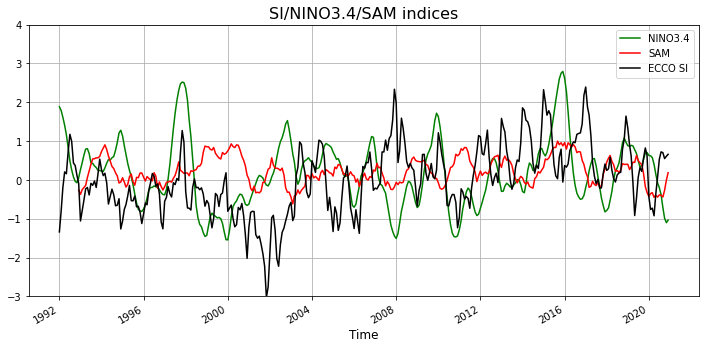

In [35]:
plt.figure(figsize=(12,5))
enso.sel(time=slice('1992', '2020')).plot(color='green', label='NINO3.4')
sam_soda_time.rolling(time=12).mean().plot(color='red', label='SAM') #12mth rolling mean
soda_mo.soda_si_index.plot(color='k', label='ECCO SI')
plt.legend()
plt.grid()
plt.ylim(-3,4) #ylims with rolling mean
#plt.ylim(-6,6) #ylims without rolling mean
#plt.xlim('1992-01-01', '2015-12-01')
plt.title('SI/NINO3.4/SAM indices', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('');

## Water mass classes timeseries

In [36]:
import sys
#telling python where the module lives
sys.path.insert(0, '/home/jovyan/WMT-project/')
from sum_wm_bins import sum_wm_bins

In [40]:
dVdt_anom_rolled.time

<xarray.DataArray 'time' (time: 985)>
array(['1993-01-07T01:00:00.000000000', '1993-01-17T01:00:00.000000000',
       '1993-01-27T01:00:00.000000000', ..., '2019-11-27T01:00:00.000000000',
       '2019-12-07T01:00:00.000000000', '2019-12-17T01:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 dask.array<chunksize=(985,), meta=np.ndarray>

In [41]:
wm_type = ['cdw', 'wsdw', 'wsbw', 'isw']

wmt_terms = [dVdt_anom_rolled, psi_vel_anom_rolled, omega_anom_rolled]

term_names = ['dVdt_anom_rolled', 'psi_vel_anom_rolled', 'omega_anom_rolled']

In [42]:
def datasetmaker(wm_term):
    """Creating new ds for each wmt budget term with wm classes as variables."""
    new_ds = xr.Dataset({'cdw': sum_wm_bins(wm_term, 'cdw'), 'wsdw':sum_wm_bins(wm_term, 'wsdw'),
                           'wsbw': sum_wm_bins(wm_term, 'wsbw'), 'isw': sum_wm_bins(wm_term, 'isw')}, attrs=dict(Name=wm_term.name))
    return new_ds

In [43]:
wmt_terms[0].name

'dVdt'

In [44]:
term_names[0]

'dVdt_anom_rolled'

In [45]:
k=0
for term in (wmt_terms):
    term_names[k] = datasetmaker(term)
    k=k+1

In [46]:
term_names[0].attrs.get('Name')

'dVdt'

In [47]:
len(term_names)

3

In [49]:
#trying to assign vars with term_names at end of name for each ds in term_names
F"wm_ds_{term_names[1].attrs.get('Name')}" #= term_names[0]

'wm_ds_psi_vel'

In [50]:
term_names[0]

<xarray.Dataset>
Dimensions:  (time: 985)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00
    month    (time) int64 dask.array<chunksize=(985,), meta=np.ndarray>
Data variables:
    cdw      (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    wsdw     (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    wsbw     (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    isw      (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
Attributes:
    Name:     dVdt

In [51]:
wm_ds_dVdt = (term_names[0]/term_names[0].std('time')).drop(['month'])
wm_ds_psi_vel = (term_names[1]/term_names[1].std('time')).drop(['month'])
wm_ds_omega_trans = (term_names[2]/term_names[2].std('time')).drop(['month'])

In [52]:
wm_ds_dVdt

<xarray.Dataset>
Dimensions:  (time: 985)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-07T01:00:00 ... 2019-12-17T01:00:00
Data variables:
    cdw      (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    wsdw     (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    wsbw     (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>
    isw      (time) float64 dask.array<chunksize=(18,), meta=np.ndarray>

## Visualize timeseries of wmt terms in wm classes, [seaice, sam, enso indices]

In [53]:
# For Visualization
import panel as pn
import holoviews as hv
from holoviews import opts
import geoviews as gv

import pandas as pd
import param as pm

## Import hvplot apis for xarray and pandas
import hvplot.xarray
import hvplot.pandas

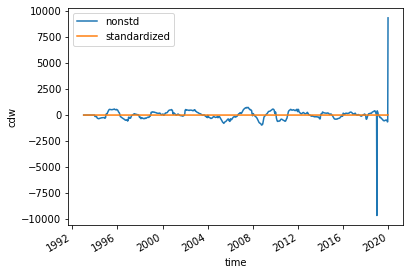

In [58]:
term_names[0].cdw.plot(label='nonstd')
wm_ds_dVdt.cdw.plot(label='standardized')
plt.legend()

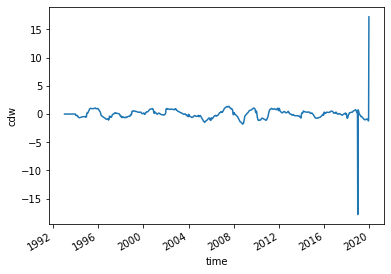

In [60]:
wm_ds_dVdt.cdw.plot()

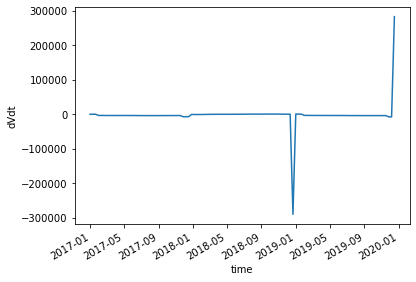

In [63]:
dVdt_anom_rolled.sel(time=slice('2017', '2020')).sum('sigma2_bin').plot()